In [1]:
import random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
MAX_STEPS      = 20       # max questions per episode
HIDDEN_SIZE    = 64
LR             = 1e-3
GAMMA          = 0.99
LAM            = 0.95
EPS_CLIP       = 0.1
ENT_COEF       = 0.01
MAX_GRAD_NORM  = 0.5
EPOCHS         = 8
BATCH_SIZE     = 128
BETA_GUESS     = 1.0
EVAL_INTERVAL  = 500     # episodes between evaluations
EVAL_GAMES     = 100     # games per evaluation
PRINT_EVERY    = 100     # episodes between printouts

In [4]:
df = pd.read_excel('knowledge_base1.xlsx')
FEATURES = ["Hair", "Feathers", "Eggs", "Milk", "Airborne", "Aquatic", "Predator", "Toothed",
            "Backbone", "Breathes", "Venomous", "Fins", "Nlegs_0", "Nlegs_2", "Nlegs_4",
            "Nlegs_5", "Nlegs_6", "Nlegs_8", "Tail", "Domestic", "Catsize",
            "Mammal", "Bird", "Reptile", "Fish", "Amphibian", "Insect", "Invertebrate"]

animal_features = df.iloc[:, 1:].values  # exclude animal name column
NUM_FEATURES = animal_features.shape[1]
NUM_ANIMALS = animal_features.shape[0]
print(f'Loaded {animal_features.shape[0]} animals with {NUM_FEATURES} features')

Loaded 100 animals with 28 features


In [5]:
class Animal20QEnv:
    def __init__(self, animal_features):
        self.animal_features    = animal_features
        self.num_animals = animal_features.shape[0]
        self.num_features= animal_features.shape[1]
        self.max_steps   = MAX_STEPS

    def reset(self):
        self.target_idx = random.randrange(self.num_animals)
        self.remaining_animals  = list(range(self.num_animals))
        self.asked_features      = set()
        self.steps      = 0
        self.state      = -1 * np.ones(self.num_features, dtype=np.int8)
        return self.state.copy()

    def step(self, action):
        answer = self.animal_features[self.target_idx, action]
        prev_remaining = len(self.remaining_animals)
        self.remaining_animals = [i for i in self.remaining_animals if self.animal_features[i,action]==answer]
        elim = prev_remaining - len(self.remaining_animals)

        # shaped reward
        reward = elim
        if elim >= 10:
            reward += 10
        if action in self.asked_features:
            reward -= 5

        self.asked_features.add(action)
        self.state[action] = int(answer)
        self.steps += 1

        done = (len(self.remaining_animals)==1) or (self.steps>=self.max_steps)
        if done:
            correct = (self.remaining_animals[0]==self.target_idx)
            reward += 30 if correct else -30

        return self.state.copy(), reward, done, {}

    def guess_animal(self):
        return self.remaining_animals[0] if self.remaining_animals else None

In [6]:
class ActorCritic(nn.Module):
    def __init__(self, state_dim, action_dim, num_animals, hidden_size=HIDDEN_SIZE):
        super().__init__()
        self.actor   = nn.Sequential(nn.Linear(state_dim, hidden_size), nn.Tanh(), nn.Linear(hidden_size, action_dim))
        self.critic  = nn.Sequential(nn.Linear(state_dim, hidden_size), nn.Tanh(), nn.Linear(hidden_size, 1))
        self.guesser = nn.Sequential(nn.Linear(state_dim, hidden_size), nn.ReLU(), nn.Linear(hidden_size, num_animals))

    def forward(self, x):
        logits, value = self.actor(x), self.critic(x).squeeze(-1)
        return logits, value

In [7]:
class PPOAgent:
    def __init__(self, state_dim, action_dim, num_animals):
        self.model     = ActorCritic(state_dim, action_dim, num_animals)
        self.optimizer = optim.Adam(self.model.parameters(), lr=LR)

    @property
    def policy_net(self):
        return self.model.actor

    @property
    def guesser_net(self):
        return self.model.guesser

    def select_action(self, state):
        st = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        logits, _ = self.model(st)
        logits = logits.squeeze(0)
        mask = (state != -1)
        logits[mask] = -1e9
        dist = Categorical(logits=logits)
        action = dist.sample().item()
        logp   = dist.log_prob(torch.tensor(action)).item()
        return action, logp

    def compute_gae(self, rewards, values, dones):
        advs = np.zeros_like(rewards, dtype=np.float32)
        last_adv = 0
        for t in reversed(range(len(rewards))):
            mask = 1.0 - dones[t]
            next_val = values[t+1] if t+1 < len(values) else values[t]
            delta = rewards[t] + GAMMA*next_val*mask - values[t]
            last_adv = delta + GAMMA*LAM*mask*last_adv
            advs[t] = last_adv
        returns = advs + values[:-1]
        advs = (advs - advs.mean())/(advs.std()+1e-8)
        return advs, returns

    def train_step(self, batch, final_states, target_idxs):
        states, actions, logps, rewards, next_states, dones = batch
        st = torch.tensor(states, dtype=torch.float32)
        ac = torch.tensor(actions)
        old_lp = torch.tensor(logps, dtype=torch.float32)
        rw = np.array(rewards, dtype=np.float32)
        dn = np.array(dones,   dtype=np.float32)

        with torch.no_grad(): _, vals = self.model(st)
        vals = vals.numpy()
        last_val = self.model(torch.tensor(next_states[-1],dtype=torch.float32).unsqueeze(0))[1].item()
        vals = np.append(vals, last_val)

        advs, rets = self.compute_gae(rw, vals, dn)
        rets_t = torch.tensor(rets, dtype=torch.float32)
        advs_t = torch.tensor(advs, dtype=torch.float32)

        dataset = torch.utils.data.TensorDataset(st, ac, old_lp, rets_t, advs_t)
        loader  = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

        for _ in range(EPOCHS):
            for b_s, b_a, b_olp, b_ret, b_adv in loader:
                logits, val = self.model(b_s)
                dist    = Categorical(logits=logits)
                entropy = dist.entropy().mean()
                new_lp  = dist.log_prob(b_a)

                ratio = torch.exp(new_lp - b_olp)
                s1    = ratio * b_adv
                s2    = torch.clamp(ratio,1-EPS_CLIP,1+EPS_CLIP)*b_adv
                p_loss= -torch.min(s1,s2).mean()
                v_loss= F.mse_loss(val, b_ret)

                fs = final_states
                tgt= target_idxs
                g_logits = self.model.guesser(fs)
                g_loss   = F.cross_entropy(g_logits, tgt)

                loss = p_loss + 0.5*v_loss - ENT_COEF*entropy + BETA_GUESS*g_loss
                self.optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_norm_(self.model.parameters(), MAX_GRAD_NORM)
                self.optimizer.step()

In [8]:
def evaluate(policy, guesser, animal_features, num_games=EVAL_GAMES, max_steps=MAX_STEPS):
    wins = 0
    total_steps = 0  
    
    for _ in range(num_games):
        idx = random.randrange(len(animal_features))
        feats = animal_features[idx]
        state = torch.zeros(NUM_FEATURES)
        asked = set()
        
        for step in range(max_steps):
            probs = policy(state.unsqueeze(0)).squeeze(0)
            mask = torch.ones_like(probs)
            mask[list(asked)] = 0
            masked = probs * mask
            masked /= masked.sum()
            a = torch.argmax(masked).item()
            asked.add(a)
            state[a] = float(feats[a])
            if len(asked) >= max_steps:
                break  # Optional, can be removed
        
        total_steps += len(asked)

        logits = guesser(state.unsqueeze(0)).squeeze(0)
        if torch.argmax(logits).item() == idx:
            wins += 1

    rate = wins / num_games
    avg_steps = total_steps / num_games
    print(f"✅ Evaluation: {wins}/{num_games} correct → Win Rate: {rate*100:.1f}% | Avg Steps: {avg_steps:.2f}")
    return rate


In [9]:
def train(agent, env, num_episodes=20000):
    success_log, avg_success = [], []
    eval_eps, eval_rates = [], []
    final_states_buf, target_buf = [], []
    episode_rewards, avg_rewards = [], []
    steps_list, avg_steps = [], []

    for ep in range(1, num_episodes + 1):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        traj = ([], [], [], [], [], [])  # state, action, log_probs, reward, next_state, done

        while not done:
            action, log_probs = agent.select_action(state)
            next_state, reward, done, _ = env.step(action)
            
            for buf, val in zip(traj, (state, action, log_probs, reward, next_state, done)):
                buf.append(val)

            total_reward += reward
            state = next_state
            steps += 1
        
        episode_rewards.append(total_reward)
        final_states_buf.append(torch.tensor(state, dtype=torch.float32))
        target_buf.append(env.target_idx)

        agent.train_step(traj,
                         torch.stack(final_states_buf),
                         torch.tensor(target_buf, dtype=torch.long))
        
        final_states_buf.clear()
        target_buf.clear()

        final_state = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
        logits = agent.guesser_net(final_state)
        pred_idx = logits.argmax(dim=1).item()
        success = int(pred_idx == env.target_idx)
        success_log.append(success)
        steps_list.append(steps)

        if ep % PRINT_EVERY == 0:
            avg_r = np.mean(episode_rewards[-PRINT_EVERY:])
            avg_s = np.mean(success_log[-PRINT_EVERY:])
            avg_step = np.mean(steps_list[-PRINT_EVERY:])
            avg_rewards.append(avg_r)
            avg_success.append(avg_s)
            avg_steps.append(avg_step)
            print(f"Episode {ep}, Reward: {avg_r:.2f}, Win Rate: {avg_s*100:.1f}%, Steps: {avg_step:.1f}")

        if ep % EVAL_INTERVAL == 0:
            wr = evaluate(agent.policy_net, agent.guesser_net, env.animal_features)
            eval_eps.append(ep)
            eval_rates.append(wr)

    return avg_rewards, avg_success, eval_eps, eval_rates, success_log, steps_list

In [10]:
env = Animal20QEnv(animal_features)
agent = PPOAgent(state_dim=NUM_FEATURES, action_dim=NUM_FEATURES, num_animals=NUM_ANIMALS)

avg_rewards, avg_success, eval_eps, eval_rates, success_log, steps_list = train(agent, env, num_episodes=20000)


/tmp/ipykernel_2670464/1192152937.py:40: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:273.)
  st = torch.tensor(states, dtype=torch.float32)


Episode 100, Reward: 120.07, Win Rate: 12.0%, Steps: 17.6
Episode 200, Reward: 126.80, Win Rate: 15.0%, Steps: 17.6
Episode 300, Reward: 125.79, Win Rate: 18.0%, Steps: 18.0
Episode 400, Reward: 136.30, Win Rate: 17.0%, Steps: 16.9
Episode 500, Reward: 129.34, Win Rate: 11.0%, Steps: 16.7
✅ Evaluation: 9/100 correct → Win Rate: 9.0% | Avg Steps: 20.00
Episode 600, Reward: 129.81, Win Rate: 12.0%, Steps: 17.2
Episode 700, Reward: 126.31, Win Rate: 25.0%, Steps: 17.4
Episode 800, Reward: 131.78, Win Rate: 19.0%, Steps: 17.5
Episode 900, Reward: 139.04, Win Rate: 23.0%, Steps: 16.9
Episode 1000, Reward: 134.07, Win Rate: 27.0%, Steps: 17.3
✅ Evaluation: 13/100 correct → Win Rate: 13.0% | Avg Steps: 20.00
Episode 1100, Reward: 132.60, Win Rate: 23.0%, Steps: 17.5
Episode 1200, Reward: 135.45, Win Rate: 32.0%, Steps: 17.7
Episode 1300, Reward: 128.92, Win Rate: 36.0%, Steps: 17.5
Episode 1400, Reward: 127.62, Win Rate: 32.0%, Steps: 16.7
Episode 1500, Reward: 136.87, Win Rate: 40.0%, Steps:

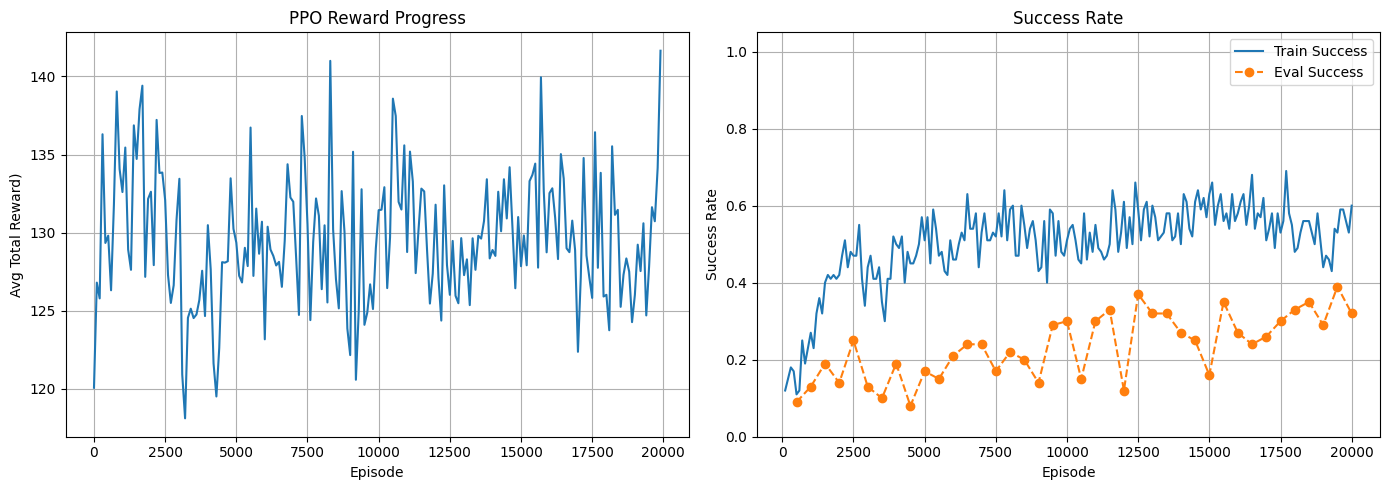

In [11]:
# Plot average total rewards
episodes = np.arange(len(avg_rewards)) * PRINT_EVERY
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(episodes, avg_rewards)
plt.title("PPO Reward Progress")
plt.xlabel("Episode")
plt.ylabel(f"Avg Total Reward)")
plt.grid()

# Plot success rates
x1 = np.arange(PRINT_EVERY, len(avg_success) * PRINT_EVERY + 1, PRINT_EVERY)
plt.subplot(1, 2, 2)
plt.plot(x1, avg_success, label="Train Success")
if eval_eps:
    plt.plot(eval_eps, eval_rates, 'o--', label="Eval Success")
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.ylim(0, 1.05)
plt.title("Success Rate")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


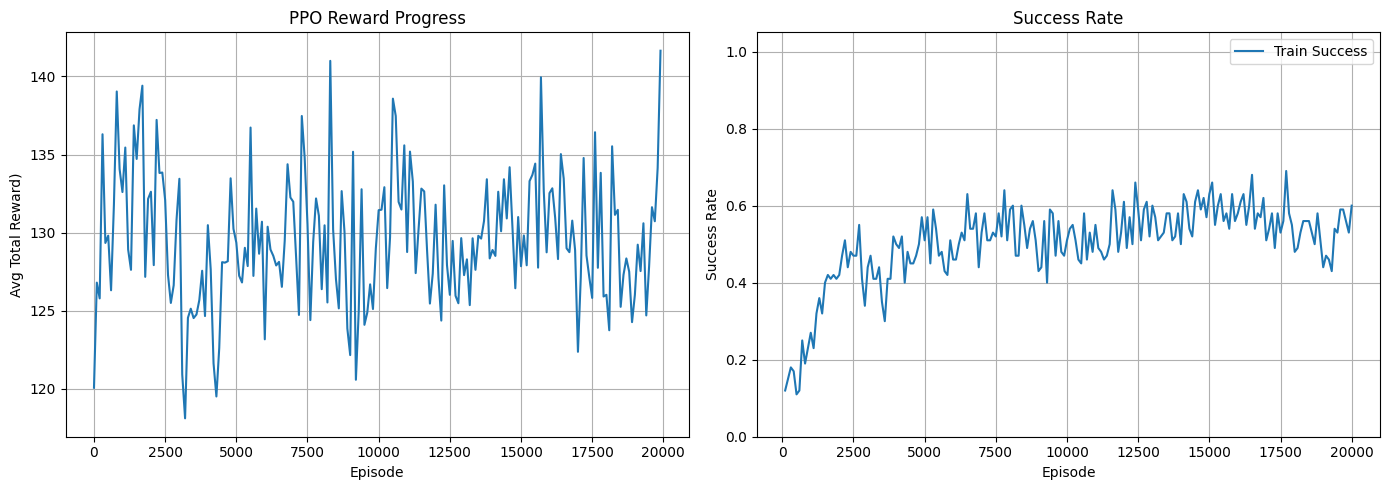

In [12]:
# Plot average total rewards
episodes = np.arange(len(avg_rewards)) * PRINT_EVERY
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(episodes, avg_rewards)
plt.title("PPO Reward Progress")
plt.xlabel("Episode")
plt.ylabel(f"Avg Total Reward)")
plt.grid()

# Plot success rates
x1 = np.arange(PRINT_EVERY, len(avg_success) * PRINT_EVERY + 1, PRINT_EVERY)
plt.subplot(1, 2, 2)
plt.plot(x1, avg_success, label="Train Success")
plt.xlabel("Episode")
plt.ylabel("Success Rate")
plt.ylim(0, 1.05)
plt.title("Success Rate")
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()


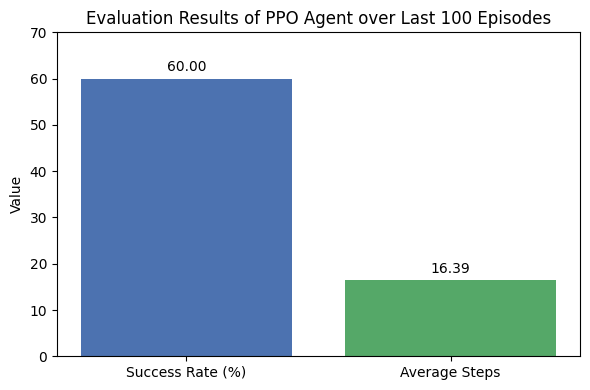

In [13]:
final_success_rate = np.mean(success_log[-100:]) * 100  # Last 100 episodes
final_avg_steps = np.mean(steps_list[-100:])

import matplotlib.pyplot as plt

# Evaluation summary
metrics = ['Success Rate (%)', 'Average Steps']
values = [final_success_rate, final_avg_steps]

# Create the plot
plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['#4C72B0', '#55A868'])

plt.title("Evaluation Results of PPO Agent over Last 100 Episodes")
plt.ylabel("Value")
plt.ylim(0, max(values) + 10)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


Highest Success Rate: 71.00%
Corresponding Average Steps: 17.14


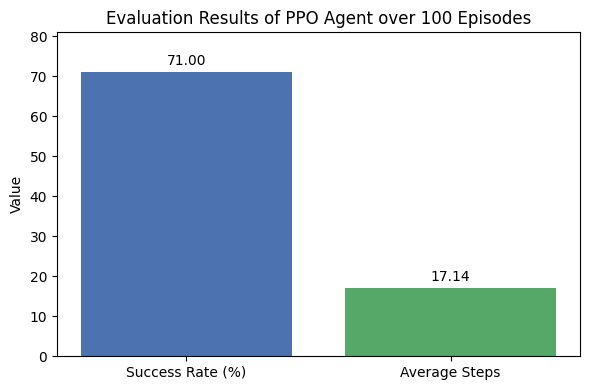

In [14]:
import numpy as np
import matplotlib.pyplot as plt

# Assume success_log and steps_list are defined lists of same length
window_size = 100

# Compute rolling averages
rolling_success_rates = [np.mean(success_log[i:i+window_size]) * 100 for i in range(len(success_log) - window_size + 1)]
rolling_avg_steps = [np.mean(steps_list[i:i+window_size]) for i in range(len(steps_list) - window_size + 1)]

# Find the max success rate and corresponding average steps
max_index = np.argmax(rolling_success_rates)
max_success_rate = rolling_success_rates[max_index]
corresponding_steps = rolling_avg_steps[max_index]

# Print the max success rate and corresponding steps
print(f"Highest Success Rate: {max_success_rate:.2f}%")
print(f"Corresponding Average Steps: {corresponding_steps:.2f}")

# Plotting
metrics = ['Success Rate (%)', 'Average Steps']
values = [max_success_rate, corresponding_steps]

plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['#4C72B0', '#55A868'])

plt.title("Evaluation Results of PPO Agent over 100 Episodes")
plt.ylabel("Value")
plt.ylim(0, max(values) + 10)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()


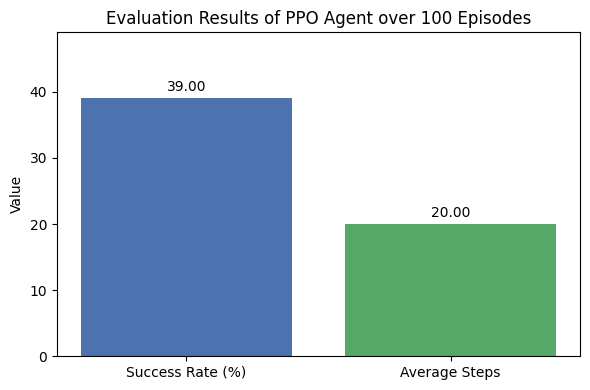

In [16]:
# Evaluation summary
metrics = ['Success Rate (%)', 'Average Steps']
values = [39, 20]

# Create the plot
plt.figure(figsize=(6, 4))
bars = plt.bar(metrics, values, color=['#4C72B0', '#55A868'])

plt.title("Evaluation Results of PPO Agent over 100 Episodes")
plt.ylabel("Value")
plt.ylim(0, max(values) + 10)

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.annotate(f'{height:.2f}',
                 xy=(bar.get_x() + bar.get_width() / 2, height),
                 xytext=(0, 3),
                 textcoords="offset points",
                 ha='center', va='bottom')

plt.tight_layout()
plt.show()
